In [1]:
import os
import random
from tqdm import tqdm
import cv2
from skimage.io import imread,imshow
from skimage.transform import resize
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import BatchNormalization
import albumentations as A
from skimage import io
from sklearn.model_selection import train_test_split

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
PATH = "dataset/treecover_segmentation_aerial_goettingen/tiles"
MASK_PATH = "dataset/treecover_segmentation_aerial_goettingen/masks"

In [4]:
train_ids = sorted(next(os.walk(PATH))[2])
mask_train_ids = sorted(next(os.walk(MASK_PATH))[2])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(train_ids,mask_train_ids , 
                                   test_size=0.2, 
                                   shuffle=True,random_state = 1043)

In [6]:
X_test

['tile_27.tif',
 'tile_2.tif',
 'tile_22.tif',
 'tile_25.tif',
 'tile_31.tif',
 'tile_33.tif',
 'tile_23.tif',
 'tile_17.tif']

In [7]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

In [8]:
images = []
for n,id_ in tqdm(enumerate(X_train),total=len(X_train)):
    path=PATH+"/"+id_
    img = plt.imread(path)
    #print(img.shape)
    image_reduced = cv2.resize(img, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
    image = np.array(image_reduced).astype(np.float32)
    #print(image.dtype)
    images.append(image)
images = np.array(images)

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.91it/s]


In [9]:
images.shape

(30, 256, 256, 4)

In [10]:
rgb_images = images[:, :, :,0:3]
rgb_images = rgb_images/255.
print(rgb_images.shape)

(30, 256, 256, 3)


In [11]:
masks=[]
for n,id_ in tqdm(enumerate(y_train),total=len(y_train)):
    path=MASK_PATH+"/"+id_
    mask = plt.imread(path)
    mask = np.array(mask).astype(np.float32)
    mask_reduced = cv2.resize(mask, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
    masks.append(mask_reduced)
masks = np.array(masks)

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 169.49it/s]


In [12]:
print("Initial shape is",masks.shape)
masks = np.expand_dims(masks, axis=3)
print("Shape of final mask",masks.shape)

Initial shape is (30, 256, 256)
Shape of final mask (30, 256, 256, 1)


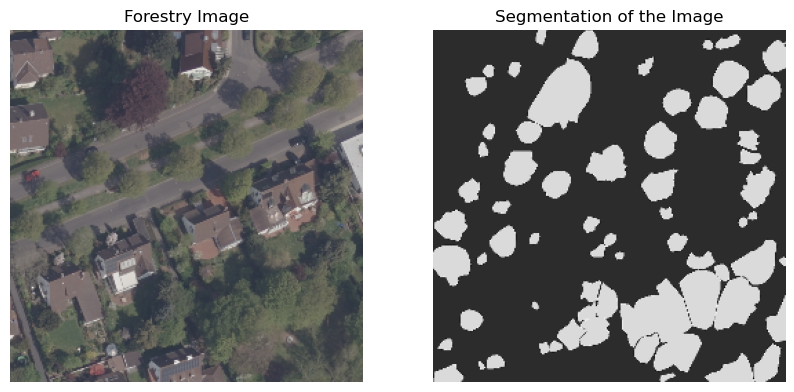

In [13]:
ix=random.randint(0,len(images))
fig = plt.figure(figsize=(10,5))
fig.add_subplot(1,2,1)
plt.axis("off")
plt.title('Forestry Image')
image = rgb_images[ix]
plt.imshow(image)
#plotting image with noise
fig.add_subplot(1,2,2)
plt.axis('off')
plt.title('Segmentation of the Image')
plt.imshow(masks[ix],cmap="gray")
plt.show()

### Data Augmentation

In [14]:
aug = A.Compose([
      A.GaussianBlur(p=0.2,blur_limit=(1,3)), #Blur the input image using a Gaussian filter with a random kernel size.
      A.Sharpen(p=0.4,alpha=(0.1,0.3),lightness=(0.0,0.0)), 
      A.ElasticTransform(p=0.3, alpha=5, sigma=100.0, alpha_affine=20, interpolation=3, border_mode=0, value=(0, 0, 0), mask_value=None, approximate=False, same_dxdy=False),
      A.GridDistortion(p=0.3, num_steps=10, distort_limit=(-0.2, 0.2), interpolation=3, border_mode=0, value=(0, 0, 0), mask_value=None, normalized=False),
      A.Flip(always_apply=False, p=0.3),
      A.OpticalDistortion(p=0.3, distort_limit=(-0.8, 0.8), shift_limit=(-0.1, 0.1), interpolation=0, border_mode=0, value=(0, 0, 0), mask_value=None),
      A.ShiftScaleRotate(p=0.3, shift_limit_x=(-0.2, 0.2), shift_limit_y=(-0.2, 0.2), scale_limit=(-0.2, 0.2), rotate_limit=(-10, 10), interpolation=3, border_mode=2, value=(0, 0, 0), mask_value=None, rotate_method='largest_box'),
      A.ColorJitter(always_apply=False, p=0.3, brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.1, 0.1)),
      A.Downscale(always_apply=False, p=0.3, scale_min=0.75, scale_max=0.85),
      A.GaussNoise(always_apply=False, p=0.3, var_limit=(0.0, 0.01), per_channel=True, mean=0.0),
      A.RGBShift(always_apply=False, p=0.3, r_shift_limit=(-0.1, 0.1), g_shift_limit=(-0.1, 0.1), b_shift_limit=(-0.1, 0.1)),
      A.RandomBrightnessContrast(p=0.3, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=False),
    ]
)

C:\Users\amit\AppData\Roaming\Python\Python39\site-packages\albumentations\augmentations\transforms.py:1554: UserWarning: Using default interpolation INTER_NEAREST, which is sub-optimal.Please specify interpolation mode for downscale and upscale explicitly.For additional information see this PR https://github.com/albumentations-team/albumentations/pull/584
  warnings.warn(


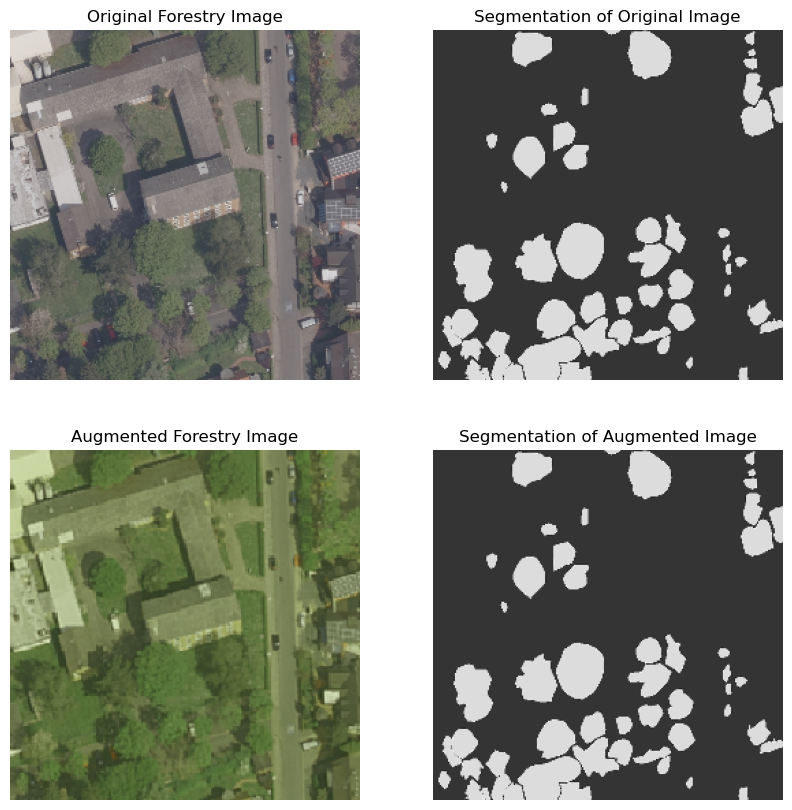

In [15]:
number = random.randint(0,len(X_train)-1)
image = rgb_images[number]
mask = masks[number]
augmented = aug(image = image, mask = mask)
augmented_image = augmented["image"]
augmented_mask = augmented["mask"]
fig = plt.figure(figsize=(10,10))
plt.subplot(221)
plt.axis("off")
plt.title('Original Forestry Image')
original_image = image
plt.imshow(original_image)
plt.subplot(223)
plt.axis("off")
plt.title('Augmented Forestry Image')
image = augmented_image
plt.imshow(image)
#plotting mask
plt.subplot(222)
plt.axis('off')
plt.title('Segmentation of Original Image')
plt.imshow(mask,cmap="gray")
plt.subplot(224)
plt.axis('off')
plt.title('Segmentation of Augmented Image')
plt.imshow(augmented_mask,cmap="gray")
plt.show()


In [16]:
images_to_generate = 400
i = 1
augmented_image = []
augmented_mask = []
while i<=images_to_generate:
    number = random.randint(0,len(X_train)-1)
    image = rgb_images[number]
    mask = masks[number]
    augmented = aug(image = image, mask = mask)
    augmented_image.append(augmented["image"])
    augmented_mask.append(augmented["mask"])
    i=i+1
augmented_image = np.array(augmented_image)
augmented_mask = np.array(augmented_mask)

In [17]:
augmented_image.shape

(400, 256, 256, 3)

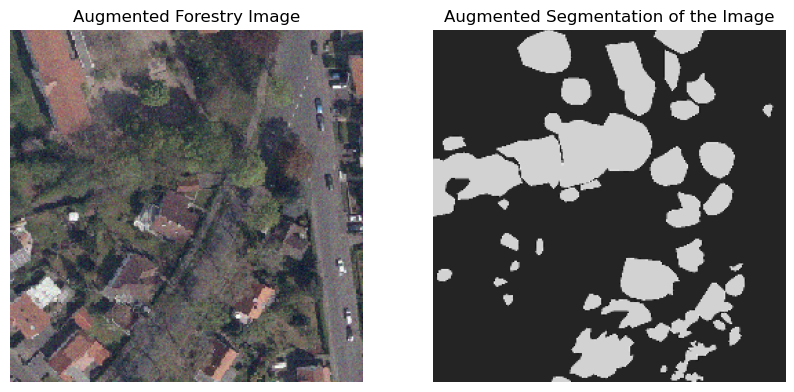

In [18]:
ix=random.randint(0,len(augmented_image))
fig = plt.figure(figsize=(10,5))
fig.add_subplot(1,2,1)
plt.axis("off")
plt.title('Augmented Forestry Image')
image = augmented_image[ix]
plt.imshow(image)
#plotting image with noise
fig.add_subplot(1,2,2)
plt.axis('off')
plt.title('Augmented Segmentation of the Image')
plt.imshow(augmented_mask[ix],cmap="gray")
plt.show()

In [19]:
X = np.concatenate((rgb_images, augmented_image), axis=0)
X.shape

(430, 256, 256, 3)

In [20]:
Y = np.concatenate((masks, augmented_mask), axis=0)
Y.shape

(430, 256, 256, 1)

In [21]:
#https://stackoverflow.com/questions/72195156/correct-implementation-of-dice-loss-in-tensorflow-keras
def dice_coef(y_true, y_pred, smooth = 1e-5):        
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

In [22]:
def dice_coef_loss(y_true, y_pred):
    dice_loss = 1- dice_coef(y_true, y_pred) 
    return dice_loss

In [23]:
def jaccard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

In [24]:
inputs = tf.keras.layers.Input((IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS),dtype=tf.float32)

### Constructing U NET

In [25]:
#Encoder
c1 = tf.keras.layers.Conv2D(32,(3,3),activation="relu",kernel_initializer = "he_normal",padding="same")(inputs)
c1 = BatchNormalization()(c1)
c1 = tf.keras.layers.Conv2D(32,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c1)
c1 = BatchNormalization()(c1)
p1=tf.keras.layers.MaxPooling2D((2,2))(c1)
p1 = tf.keras.layers.Dropout(0.2)(p1)

In [26]:
c2=tf.keras.layers.Conv2D(64,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(p1)
c2 = BatchNormalization()(c2)
c2=tf.keras.layers.Conv2D(64,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c2)
c2 = BatchNormalization()(c2)
p2= tf.keras.layers.MaxPooling2D((2,2))(c2)
p2 = tf.keras.layers.Dropout(0.3)(p2)

In [27]:
c3=tf.keras.layers.Conv2D(128,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(p2)
c3 = BatchNormalization()(c3)
c3=tf.keras.layers.Conv2D(128,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c3)
c3 = BatchNormalization()(c3)
p3=tf.keras.layers.MaxPooling2D((2,2))(c3)
p3=tf.keras.layers.Dropout(0.3)(p3)

In [28]:
c4=tf.keras.layers.Conv2D(256,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(p3)
c4 = BatchNormalization()(c4)
c4=tf.keras.layers.Conv2D(256,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c4)
c4 = BatchNormalization()(c4)

In [29]:
#expansive path

In [30]:
u5 = tf.keras.layers.Conv2DTranspose(128,(2,2),strides=(2,2),padding="same")(c4)
u5=tf.keras.layers.concatenate([u5,c3])
u5=tf.keras.layers.Dropout(0.3)(u5)
c5=tf.keras.layers.Conv2D(128,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(u5)
c5 = BatchNormalization()(c5)
c5=tf.keras.layers.Conv2D(128,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c5)
c5 = BatchNormalization()(c5)

In [31]:
u6 = tf.keras.layers.Conv2DTranspose(64,(2,2),strides=(2,2),padding="same")(c5)
u6=tf.keras.layers.concatenate([u6,c2])
u6=tf.keras.layers.Dropout(0.3)(u6)
c6=tf.keras.layers.Conv2D(64,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(u6)
c6 = BatchNormalization()(c6)
c6=tf.keras.layers.Conv2D(64,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c6)
c6 = BatchNormalization()(c6)

In [32]:
u7 = tf.keras.layers.Conv2DTranspose(32,(2,2),strides=(2,2),padding="same")(c6)
u7=tf.keras.layers.concatenate([u7,c1])
u7=tf.keras.layers.Dropout(0.3)(u7)
c7=tf.keras.layers.Conv2D(32,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(u7)
c7 = BatchNormalization()(c7)
c7=tf.keras.layers.Conv2D(32,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c7)
c7 = BatchNormalization()(c7)

In [33]:
outputs=tf.keras.layers.Conv2D(1,(1,1),activation="sigmoid")(c7)

In [34]:
model_forestry=tf.keras.Model(inputs=[inputs],outputs=[outputs])
model_forestry.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),loss=dice_coef_loss,metrics=[jaccard_coef])
model_forestry.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

 spose)                         )                                                                 
                                                                                                  
 concatenate_1 (Concatenate)    (None, 128, 128, 12  0           ['conv2d_transpose_1[0][0]',     
                                8)                                'batch_normalization_3[0][0]']  
                                                                                                  
 dropout_4 (Dropout)            (None, 128, 128, 12  0           ['concatenate_1[0][0]']          
                                8)                                                                
                                                                                                  
 conv2d_10 (Conv2D)             (None, 128, 128, 64  73792       ['dropout_4[0][0]']              
                                )                                                                 
          

C:\ProgramData\Anaconda3\envs\py39\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [35]:
checkpointer= tf.keras.callbacks.ModelCheckpoint("./segmentation_32_400aug.h5",verbose=1,save_best_only=True)

In [36]:
callbacks=[
    tf.keras.callbacks.EarlyStopping(patience=10,monitor="val_loss"),
    tf.keras.callbacks.TensorBoard(log_dir="logs"),
    checkpointer
]

In [37]:
 results = model_forestry.fit(X,Y,validation_split=0.2,batch_size=8,epochs=300,callbacks=callbacks)

Epoch 1/300
43/43 [==============================] - ETA: 0s - loss: 0.5916 - jaccard_coef: 0.2581
Epoch 1: val_loss improved from inf to 0.60336, saving model to .\segmentation_32_400aug.h5
43/43 [==============================] - 77s 1s/step - loss: 0.5916 - jaccard_coef: 0.2581 - val_loss: 0.6034 - val_jaccard_coef: 0.2474
Epoch 2/300
43/43 [==============================] - ETA: 0s - loss: 0.4789 - jaccard_coef: 0.3539
Epoch 2: val_loss improved from 0.60336 to 0.59103, saving model to .\segmentation_32_400aug.h5
43/43 [==============================] - 56s 1s/step - loss: 0.4789 - jaccard_coef: 0.3539 - val_loss: 0.5910 - val_jaccard_coef: 0.2572
Epoch 3/300
43/43 [==============================] - ETA: 0s - loss: 0.4324 - jaccard_coef: 0.3970
Epoch 3: val_loss did not improve from 0.59103
43/43 [==============================] - 54s 1s/step - loss: 0.4324 - jaccard_coef: 0.3970 - val_loss: 0.5913 - val_jaccard_coef: 0.2570
Epoch 4/300
43/43 [==============================] - ETA:

Epoch 27/300
43/43 [==============================] - ETA: 0s - loss: 0.2876 - jaccard_coef: 0.5542
Epoch 27: val_loss did not improve from 0.38862
43/43 [==============================] - 54s 1s/step - loss: 0.2876 - jaccard_coef: 0.5542 - val_loss: 0.3907 - val_jaccard_coef: 0.4402
Epoch 28/300
43/43 [==============================] - ETA: 0s - loss: 0.2892 - jaccard_coef: 0.5523
Epoch 28: val_loss did not improve from 0.38862
43/43 [==============================] - 40s 922ms/step - loss: 0.2892 - jaccard_coef: 0.5523 - val_loss: 0.3917 - val_jaccard_coef: 0.4393
Epoch 29/300
43/43 [==============================] - ETA: 0s - loss: 0.2895 - jaccard_coef: 0.5521
Epoch 29: val_loss improved from 0.38862 to 0.38568, saving model to .\segmentation_32_400aug.h5
43/43 [==============================] - 56s 1s/step - loss: 0.2895 - jaccard_coef: 0.5521 - val_loss: 0.3857 - val_jaccard_coef: 0.4454
Epoch 30/300
43/43 [==============================] - ETA: 0s - loss: 0.2821 - jaccard_coef: 

43/43 [==============================] - ETA: 0s - loss: 0.2337 - jaccard_coef: 0.6219
Epoch 54: val_loss did not improve from 0.31755
43/43 [==============================] - 55s 1s/step - loss: 0.2337 - jaccard_coef: 0.6219 - val_loss: 0.3180 - val_jaccard_coef: 0.5190
Epoch 55/300
43/43 [==============================] - ETA: 0s - loss: 0.2326 - jaccard_coef: 0.6234
Epoch 55: val_loss did not improve from 0.31755
43/43 [==============================] - 55s 1s/step - loss: 0.2326 - jaccard_coef: 0.6234 - val_loss: 0.3274 - val_jaccard_coef: 0.5080
Epoch 56/300
43/43 [==============================] - ETA: 0s - loss: 0.2309 - jaccard_coef: 0.6255
Epoch 56: val_loss improved from 0.31755 to 0.30655, saving model to .\segmentation_32_400aug.h5
43/43 [==============================] - 56s 1s/step - loss: 0.2309 - jaccard_coef: 0.6255 - val_loss: 0.3066 - val_jaccard_coef: 0.5321
Epoch 57/300
43/43 [==============================] - ETA: 0s - loss: 0.2297 - jaccard_coef: 0.6274
Epoch 57:

43/43 [==============================] - ETA: 0s - loss: 0.1945 - jaccard_coef: 0.6752
Epoch 81: val_loss did not improve from 0.26809
43/43 [==============================] - 55s 1s/step - loss: 0.1945 - jaccard_coef: 0.6752 - val_loss: 0.2757 - val_jaccard_coef: 0.5686
Epoch 82/300
43/43 [==============================] - ETA: 0s - loss: 0.1906 - jaccard_coef: 0.6804
Epoch 82: val_loss did not improve from 0.26809
43/43 [==============================] - 55s 1s/step - loss: 0.1906 - jaccard_coef: 0.6804 - val_loss: 0.2747 - val_jaccard_coef: 0.5701
Epoch 83/300
43/43 [==============================] - ETA: 0s - loss: 0.1912 - jaccard_coef: 0.6797
Epoch 83: val_loss did not improve from 0.26809
43/43 [==============================] - 55s 1s/step - loss: 0.1912 - jaccard_coef: 0.6797 - val_loss: 0.2713 - val_jaccard_coef: 0.5742
Epoch 84/300
43/43 [==============================] - ETA: 0s - loss: 0.1917 - jaccard_coef: 0.6794
Epoch 84: val_loss did not improve from 0.26809
43/43 [===

Epoch 108/300
43/43 [==============================] - ETA: 0s - loss: 0.1670 - jaccard_coef: 0.7146
Epoch 108: val_loss did not improve from 0.23649
43/43 [==============================] - 55s 1s/step - loss: 0.1670 - jaccard_coef: 0.7146 - val_loss: 0.2377 - val_jaccard_coef: 0.6172
Epoch 109/300
43/43 [==============================] - ETA: 0s - loss: 0.1634 - jaccard_coef: 0.7196
Epoch 109: val_loss improved from 0.23649 to 0.23636, saving model to .\segmentation_32_400aug.h5
43/43 [==============================] - 56s 1s/step - loss: 0.1634 - jaccard_coef: 0.7196 - val_loss: 0.2364 - val_jaccard_coef: 0.6189
Epoch 110/300
43/43 [==============================] - ETA: 0s - loss: 0.1606 - jaccard_coef: 0.7237
Epoch 110: val_loss improved from 0.23636 to 0.22986, saving model to .\segmentation_32_400aug.h5
43/43 [==============================] - 56s 1s/step - loss: 0.1606 - jaccard_coef: 0.7237 - val_loss: 0.2299 - val_jaccard_coef: 0.6277
Epoch 111/300
43/43 [====================

43/43 [==============================] - ETA: 0s - loss: 0.1436 - jaccard_coef: 0.7491
Epoch 135: val_loss did not improve from 0.21285
43/43 [==============================] - 55s 1s/step - loss: 0.1436 - jaccard_coef: 0.7491 - val_loss: 0.2195 - val_jaccard_coef: 0.6411
Epoch 136/300
43/43 [==============================] - ETA: 0s - loss: 0.1428 - jaccard_coef: 0.7504
Epoch 136: val_loss improved from 0.21285 to 0.20486, saving model to .\segmentation_32_400aug.h5
43/43 [==============================] - 56s 1s/step - loss: 0.1428 - jaccard_coef: 0.7504 - val_loss: 0.2049 - val_jaccard_coef: 0.6608
Epoch 137/300
43/43 [==============================] - ETA: 0s - loss: 0.1415 - jaccard_coef: 0.7524
Epoch 137: val_loss did not improve from 0.20486
43/43 [==============================] - 55s 1s/step - loss: 0.1415 - jaccard_coef: 0.7524 - val_loss: 0.2233 - val_jaccard_coef: 0.6363
Epoch 138/300
43/43 [==============================] - ETA: 0s - loss: 0.1399 - jaccard_coef: 0.7550
Epo

Epoch 163/300
43/43 [==============================] - ETA: 0s - loss: 0.1268 - jaccard_coef: 0.7753
Epoch 163: val_loss did not improve from 0.19665
43/43 [==============================] - 55s 1s/step - loss: 0.1268 - jaccard_coef: 0.7753 - val_loss: 0.1998 - val_jaccard_coef: 0.6680
Epoch 164/300
43/43 [==============================] - ETA: 0s - loss: 0.1276 - jaccard_coef: 0.7742
Epoch 164: val_loss did not improve from 0.19665
43/43 [==============================] - 55s 1s/step - loss: 0.1276 - jaccard_coef: 0.7742 - val_loss: 0.1974 - val_jaccard_coef: 0.6714
Epoch 165/300
43/43 [==============================] - ETA: 0s - loss: 0.1277 - jaccard_coef: 0.7739
Epoch 165: val_loss improved from 0.19665 to 0.19602, saving model to .\segmentation_32_400aug.h5
43/43 [==============================] - 56s 1s/step - loss: 0.1277 - jaccard_coef: 0.7739 - val_loss: 0.1960 - val_jaccard_coef: 0.6734
Epoch 166/300
43/43 [==============================] - ETA: 0s - loss: 0.1233 - jaccard_co

Epoch 191/300
43/43 [==============================] - ETA: 0s - loss: 0.1153 - jaccard_coef: 0.7936
Epoch 191: val_loss did not improve from 0.18555
43/43 [==============================] - 54s 1s/step - loss: 0.1153 - jaccard_coef: 0.7936 - val_loss: 0.1881 - val_jaccard_coef: 0.6847
Epoch 192/300
43/43 [==============================] - ETA: 0s - loss: 0.1173 - jaccard_coef: 0.7904
Epoch 192: val_loss did not improve from 0.18555
43/43 [==============================] - 55s 1s/step - loss: 0.1173 - jaccard_coef: 0.7904 - val_loss: 0.1862 - val_jaccard_coef: 0.6870
Epoch 193/300
43/43 [==============================] - ETA: 0s - loss: 0.1131 - jaccard_coef: 0.7972
Epoch 193: val_loss improved from 0.18555 to 0.18486, saving model to .\segmentation_32_400aug.h5
43/43 [==============================] - 56s 1s/step - loss: 0.1131 - jaccard_coef: 0.7972 - val_loss: 0.1849 - val_jaccard_coef: 0.6892
Epoch 194/300
43/43 [==============================] - ETA: 0s - loss: 0.1125 - jaccard_co

C:\Users\amit\AppData\Local\Temp\ipykernel_9808\474904835.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)). The keyword argument will take precedence.
  plt.plot(epochs, dice_coef, 'b', label='Train IoU score',color="blue")
C:\Users\amit\AppData\Local\Temp\ipykernel_9808\474904835.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_dice_coef, 'b', label='Val IoU score',color="orange")
C:\Users\amit\AppData\Local\Temp\ipykernel_9808\474904835.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)). The keyword argument will take precedence.
  plt.p

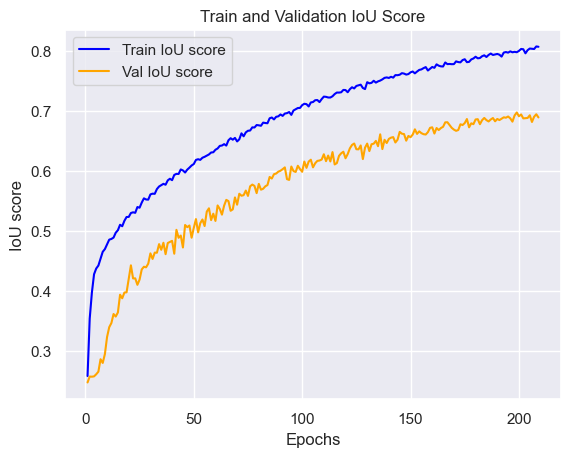

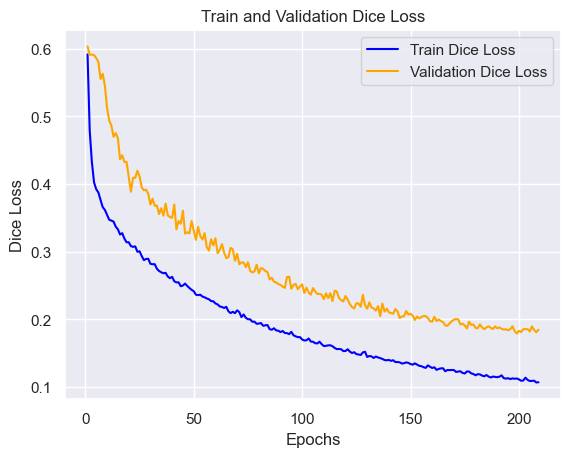

In [42]:
import seaborn as sns
sns.set()
dice_coef = results.history['jaccard_coef']
val_dice_coef = results.history['val_jaccard_coef']
loss = results.history['loss']
val_loss = results.history['val_loss']
import matplotlib.pyplot as plt
epochs = range(1, len(dice_coef) + 1)

plt.plot(epochs, dice_coef, 'b', label='Train IoU score',color="blue")
plt.plot(epochs, val_dice_coef, 'b', label='Val IoU score',color="orange")
plt.title('Train and Validation IoU Score')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("IoU score")


plt.figure()
plt.plot(epochs, loss, 'b', label='Train Dice Loss',color="blue")
plt.plot(epochs, val_loss, 'b', label='Validation Dice Loss',color="orange")
plt.title('Train and Validation Dice Loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Dice Loss")
plt.show()

### Checking Prediction on Test Data set

In [72]:
test_images = []
for n,id_ in tqdm(enumerate(X_test),total=len(X_test)):
    path=PATH+"/"+id_
    img = plt.imread(path)
    #print(img.shape)
    image_reduced = cv2.resize(img, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
    image = np.array(image_reduced).astype(np.float32)
    #print(image.dtype)
    test_images.append(image)
test_images = np.array(test_images)

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 48.77it/s]


In [73]:
rgb_test_images = test_images[:, :, :,0:3]
rgb_test_images = rgb_test_images/255.
print(rgb_test_images.shape)

(8, 256, 256, 3)


In [74]:
test_masks = []
for n,id_ in tqdm(enumerate(y_test),total=len(y_test)):
    path=MASK_PATH+"/"+id_
    mask = plt.imread(path)
    #print(img.shape)
    mask_reduced = cv2.resize(mask, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
    mask = np.array(mask_reduced).astype(np.float32)
    #print(image.dtype)
    test_masks.append(mask)
test_masks = np.array(test_masks)

100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 181.68it/s]


In [75]:
print("Initial shape is",test_masks.shape)
test_masks = np.expand_dims(test_masks, axis=3)
print("Shape of final mask",test_masks.shape)

Initial shape is (8, 256, 256)
Shape of final mask (8, 256, 256, 1)


In [83]:
y_pred=model_forestry.predict(rgb_test_images)
y_pred_thresholded = y_pred > 0.9

1/1 [==============================] - 1s 547ms/step


In [84]:
intersection = np.logical_and(test_masks, y_pred_thresholded)
union = np.logical_or(test_masks, y_pred_thresholded)
IoU_score = (np.sum(intersection)) / np.sum(union)
print("IoU score on test dataset is: ", IoU_score)

IoU score on test dataset is:  0.6607473720900369


In [85]:
def prediction_on_test_image(input_image):
    img_batch = np.expand_dims(input_image, axis=0)

    #prediction = model_forestry.predict(img_batch)
    prediction = (model_forestry.predict(img_batch)[0,:,:,0] > 0.5).astype(np.uint8)
    prediction = prediction
    return prediction
test_image_number = random.randint(0,len(rgb_test_images))
test_image = rgb_test_images[5]
prediction = prediction_on_test_image(test_image) 
test_image_mask = test_masks[test_image_number]

1/1 [==============================] - 7s 7s/step


In [86]:
import matplotlib as mt

In [87]:
mt.rc_file_defaults()

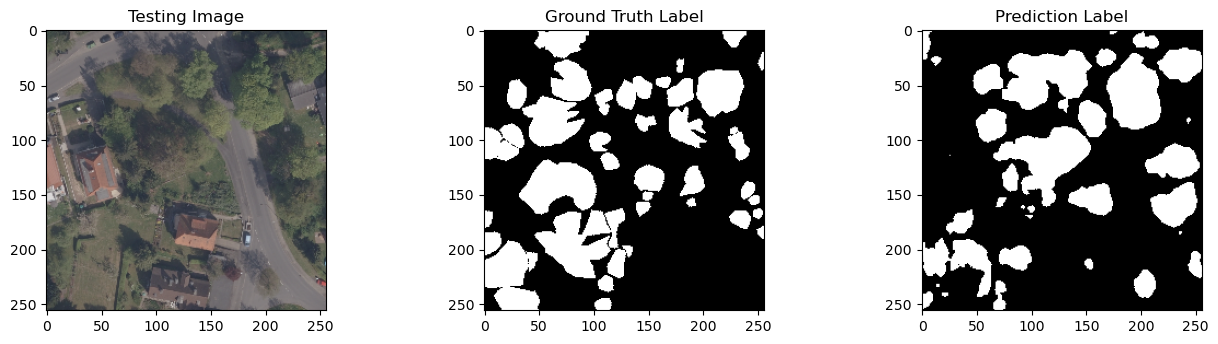

In [101]:
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_image)
plt.subplot(232)
plt.title('Ground Truth Label')
plt.imshow(test_image_mask, cmap='gray')
plt.subplot(233)
plt.title('Prediction Label')
plt.imshow(prediction, cmap='gray')
# plt.savefig("output.png")

plt.show()

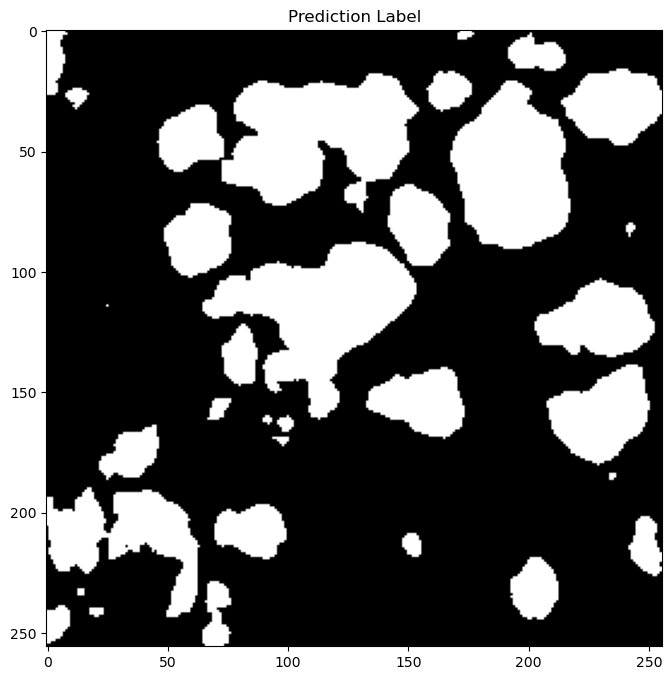

In [91]:
plt.figure(figsize=(16, 8))
# plt.subplot(231)
# plt.title('Testing Image')
# plt.imshow(test_image)
# plt.subplot(232)
# plt.title('Ground Truth Label')
# plt.imshow(test_image_mask, cmap='gray')
plt.subplot(111)
plt.title('Prediction Label')
plt.imshow(prediction, cmap='gray')
plt.savefig("output.png")

plt.show()

In [94]:
from PIL import Image

In [97]:
pred_out = Image.fromarray(np.uint8(prediction*255))

In [104]:
input_image = Image.fromarray(np.uint8(test_image*255))

In [105]:
input_image.save("unet_input_33.png")